In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 0. Read data




In [3]:
# I think these types make sense, but feel free to change (Karin)
dtype_infos = {
  "simulationPrice": np.float64,
  "promotion": str,
}
dtype_items = {
  "brand": np.uint16,
  "manufacturer": np.uint16,
  "customerRating": np.float64,
  "category1": np.uint16,
  "category2": np.uint16,
  "category3": np.uint16,
  "recommendedRetailPrice": np.float64,
}
dtype_orders = {
  "transactID": np.uint32,
  "itemID": np.uint16,
  "order": np.uint16,
  "salesPrice": np.float64,
}

In [4]:
# Should we use itemID as ID in pandas (in tables 'infos' and 'items')? I think this might speed up learning the model (when we come to that :) )
info = pd.read_csv('gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/infos.csv', delimiter='|', dtype=dtype_infos)
items = pd.read_csv('gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/items.csv', delimiter='|', dtype=dtype_items)
orders = pd.read_csv('gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/orders.csv', delimiter='|', dtype=dtype_orders, parse_dates=True)

# 1. Info

In [ ]:
info.describe()

,itemID,simulationPrice
count,10463.000000,10463.000000
mean,5232.000000,122.010808
std,3020.552267,469.701306
min,1.000000,0.380000
25%,2616.500000,8.990000
50%,5232.000000,23.830000
75%,7847.500000,63.125000
max,10463.000000,9055.070000


In [ ]:
promote = pd.DataFrame()
promote["promoted"] = info.itemID.count() - info.promotion[info['promotion'].isnull()].count()
promote



,promoted


Check if there is any null values in the info field:

In [ ]:
info.isnull().values.any()

True

In [ ]:
info[info.isnull().any(axis=1)] 

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN
...,...,...,...
10458,10459,14.71,NaN
10459,10460,325.67,NaN
10460,10461,190.53,NaN
10461,10462,304.30,NaN


In [ ]:
def price_of_promoted_items(show_only_promoted: bool = False):
  """
  Check how expensive are the items that are promoted in the simulation
  period.
  """
  def count_promotions(idx):
    if pd.isna(info.promotion[idx]):
      return 0
    return len(info.promotion[idx].split(","))

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
  ax0, ax1 = axes.flatten()

  grouped = info.groupby(count_promotions).simulationPrice.apply(list)
  if show_only_promoted:
    grouped.drop(index=0, inplace=True)
  data = grouped.sort_values("index", ascending=False)

  label = [str(k) + " promotion" + ("" if k == 1 else "s") for k in data.index]
  ax0.hist(data, bins=50, rwidth=0.9, log=True, label=label, stacked=True)
  ax1.hist(data, bins=50, rwidth=0.9, log=False, label=label, stacked=True)

  ax0.set_ylim(bottom=0.9)
  ax0.set_ylabel("Number of items (log)")
  ax1.set_ylabel("Number of items")
  ax1.set_xlabel("simulationPrice")
  ax0.legend()
  ax1.legend()

Same data plotted using two different scales (logarithmic and linear). The lower chart is there only to show that only a very few of items are promoted more than once.

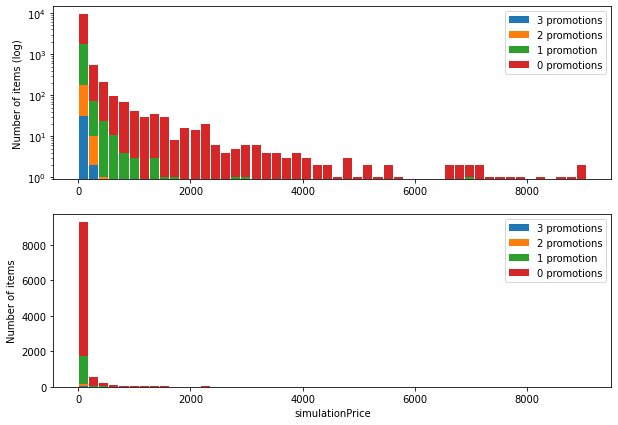

In [ ]:
price_of_promoted_items()

Same as above, but only showing items that are promoted (skipping items without promotions). Promoted items with high simulationPrice are easier to spot here.

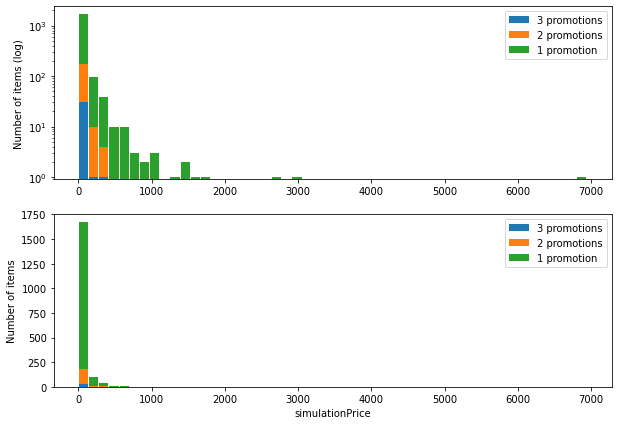

In [ ]:
price_of_promoted_items(show_only_promoted=True)

# 2. Items

In [ ]:
items

NameError: ignored

In [ ]:
d = items[["customerRating","recommendedRetailPrice"]]
d.loc[d["customerRating"] == 0,"customerRating"] = np.nan
d.describe()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customerRating,recommendedRetailPrice
count,3346.000000,10463.000000
mean,4.405822,118.283142
std,1.028295,339.338973
min,1.000000,2.460000
25%,4.000000,13.950000
50%,5.000000,24.220000
75%,5.000000,67.920000
max,5.000000,6955.000000


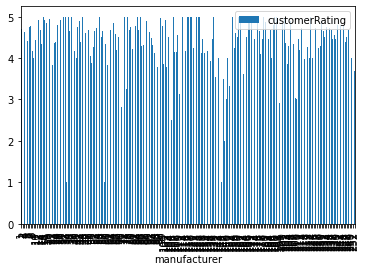

In [ ]:
# items[['manufacturer', 'customerRating']].groupby('manufacturer').mean().plot.bar()

# We must not include zeros in calculation of mean rating (0.0 means no rating)
items[['manufacturer', 'customerRating']].loc[items['customerRating'] > 0].groupby('manufacturer').mean().plot.bar()

# TODO SORT IT 

In [ ]:
items['has_rating'] = items['customerRating'] > 0

In [ ]:
items[['brand','itemID']].groupby('brand').count().sort_values(['itemID'], ascending = False)
# brand 0 means no brand!

# feature engineering: could create feature with importance of the brand -> certain brands are favored 

,itemID
brand,
0,5232
101,242
82,198
93,161
116,125
...,...
232,1
135,1
133,1


In [ ]:
items.isnull().values.any()

False

In [ ]:
def plot_ratings(attr: str, limit: int = 0):
  grouped = items[items.customerRating > 0].groupby(attr).customerRating.apply(list)
  if attr == "brand":
    # brand = 0 means no brand. Ignore items without brand.
    grouped.drop(index=0, inplace=True)
  data = grouped[grouped.apply(lambda x: len(x) >= limit)]
  support = data.apply(len)

  fig1, ax1 = plt.subplots(figsize=(10,7))
  plt.xticks(rotation=90)

  # Boxplot for customerRating
  ax1.boxplot(data, labels=data.index)
  ax1.set_xlabel(attr)
  ax1.set_ylabel("customerRating\n(boxplot)")

  title = f"customerRating for {attr}"
  if limit > 0:
    title += f" with at least {limit} rated items"
  ax1.set_title(title)

  # Barplot for number of ratings
  ax2 = ax1.twinx()
  ax2.bar(np.arange(1, len(support) + 1), height=support, alpha=0.3, width=0.9)
  ax2.set_ylabel(f"Number of items for specific {attr}\n(barplot)")

Boxplot shows distributions of customer ratings (orange line is the median). Scale is on the left.

Blue columns (barplot) show number of items sold for given attribute (brand/category/manufacturer). Scale is on the right.

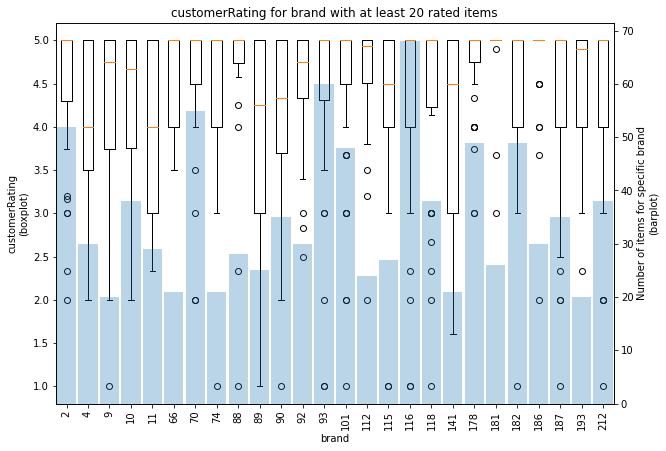

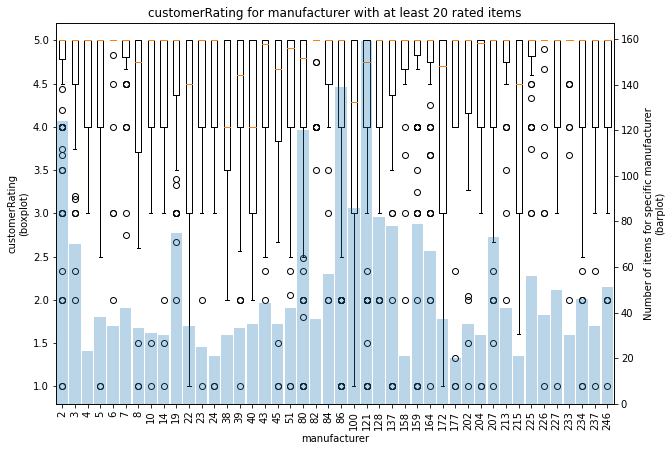

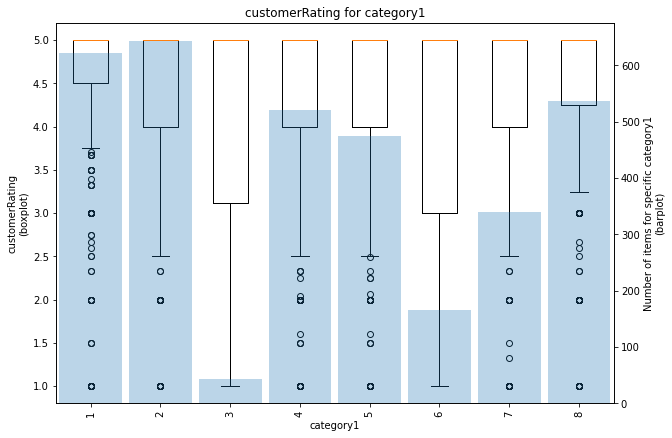

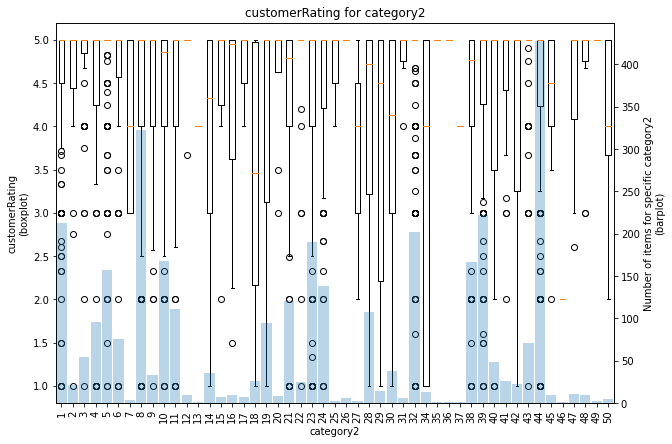

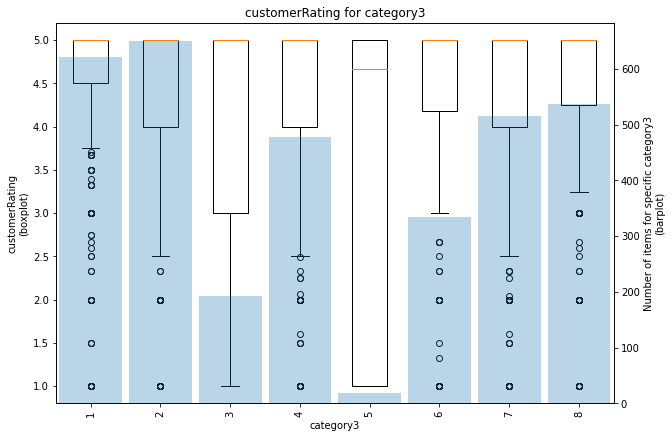

In [ ]:
plot_ratings("brand", 20)
plot_ratings("manufacturer", 20)
plot_ratings("category1")
plot_ratings("category2")
plot_ratings("category3")

## Categories n Co

In [ ]:
# List of categories2 that are in each category1 (so, if category1=1, category2 is one of [1,2, 3, 4, 5, 6, 7])
items.groupby("category1").category2.apply(list).apply(set)

category1
1                       {1, 2, 3, 4, 5, 6, 7}
2                      {8, 9, 10, 11, 13, 17}
3                            {34, 12, 29, 31}
4                    {38, 39, 40, 41, 42, 14}
5                        {32, 15, 21, 28, 30}
6                    {16, 18, 19, 20, 22, 27}
7            {33, 35, 36, 37, 23, 24, 25, 26}
8    {43, 44, 45, 46, 47, 48, 49, 50, 51, 52}
Name: category2, dtype: object

In [ ]:
# Vice versa: every category2 is in exactly one category1.
items.groupby("category2").category1.apply(list).apply(set)

category2
1     {1}
2     {1}
3     {1}
4     {1}
5     {1}
6     {1}
7     {1}
8     {2}
9     {2}
10    {2}
11    {2}
12    {3}
13    {2}
14    {4}
15    {5}
16    {6}
17    {2}
18    {6}
19    {6}
20    {6}
21    {5}
22    {6}
23    {7}
24    {7}
25    {7}
26    {7}
27    {6}
28    {5}
29    {3}
30    {5}
31    {3}
32    {5}
33    {7}
34    {3}
35    {7}
36    {7}
37    {7}
38    {4}
39    {4}
40    {4}
41    {4}
42    {4}
43    {8}
44    {8}
45    {8}
46    {8}
47    {8}
48    {8}
49    {8}
50    {8}
51    {8}
52    {8}
Name: category1, dtype: object

In [ ]:
# same idea for checking category 1 vs. category 3 -> no clear separation  
items.groupby("category1").category3.apply(list).apply(set)

category1
1                {1}
2          {8, 2, 6}
3    {2, 3, 4, 5, 6}
4          {2, 6, 7}
5          {2, 3, 4}
6          {2, 3, 6}
7          {3, 4, 6}
8                {8}
Name: category3, dtype: object

In [ ]:
items.groupby("category3").category1.apply(list).apply(set)

category3
1                {1}
2    {2, 3, 4, 5, 6}
3       {3, 5, 6, 7}
4          {3, 5, 7}
5                {3}
6    {2, 3, 4, 6, 7}
7                {4}
8             {8, 2}
Name: category1, dtype: object

Some information about the different groups in Category 1

In [ ]:
items[['recommendedRetailPrice','category1']].groupby('category1').describe()

recommendedRetailPrice              ...                   
                           count        mean  ...       75%      max
category1                                     ...                   
1                         1823.0  162.989813  ...  103.0800  6214.89
2                         2348.0   39.589915  ...   37.3000   557.70
3                          300.0  350.684067  ...  241.1400  6955.00
4                          969.0   18.271259  ...   20.0200   894.72
5                         1679.0   19.905533  ...   19.3200   220.89
6                          489.0   56.242679  ...   34.0800  1767.30
7                         1121.0   26.045210  ...   25.8700  1398.60
8                         1734.0  365.904354  ...  386.0025  4648.35

[8 rows x 8 columns]

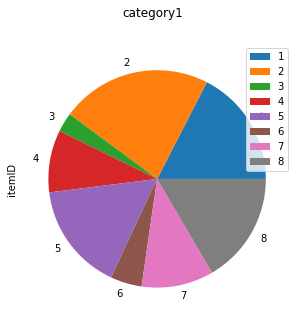

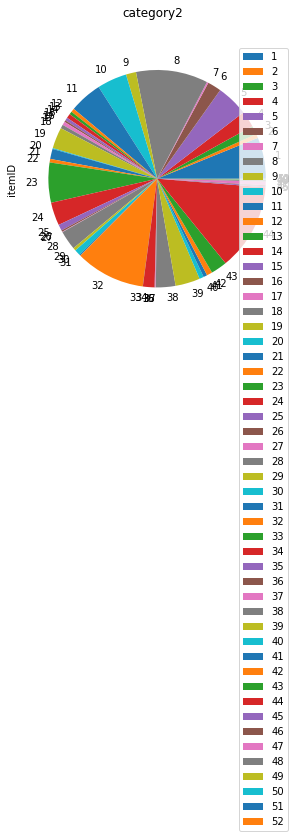

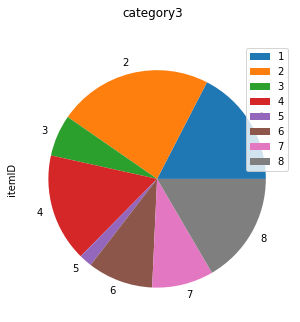

In [ ]:
for i in range(1, 4):
  items[['itemID',f'category{i}']].groupby(f'category{i}').count().plot.pie(subplots=True,figsize=(5, 5),title=f'category{i}')

# Orders

In [ ]:
orders.describe()

,transactID,itemID,order,salesPrice
count,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06
mean,1.073262e+06,5.247717e+03,1.244553e+00,3.668124e+01
std,6.312578e+05,2.454623e+03,6.665127e-01,1.261080e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,5.313775e+05,3.605000e+03,1.000000e+00,7.120000e+00
50%,1.065659e+06,5.200000e+03,1.000000e+00,1.668000e+01
75%,1.600670e+06,7.314000e+03,1.000000e+00,3.462000e+01
max,2.294042e+06,1.046300e+04,1.000000e+02,9.387020e+03


In [ ]:
orders.dtypes

time           object
transactID     uint32
itemID         uint16
order          uint16
salesPrice    float64
dtype: object

In [ ]:
descriptive = pd.DataFrame()
descriptive["min"] = orders[["time"]].min()
descriptive["max"] = orders[["time"]].max()
descriptive

descriptive2 = pd.DataFrame()
descriptive2["count"] = orders[["transactID"]].count()
descriptive2

,count
transactID,2181955


In [7]:
orders['timestamp'] = orders['time']
orders['time'] = pd.to_datetime(orders['time'])
orders['date'] = orders['time'].dt.strftime('%Y%m%d')
orders['hour'] = orders['time'].dt.hour
orders['day_of_month'] = orders['time'].dt.day
orders['month'] = orders['time'].dt.month
orders['week_nr'] = orders['time'].apply(lambda x: str(x.isocalendar()[1]))

"""
Please see the note in the cell below (about indexing timestamp)
"""
# Add the timestamp as index
orders = orders.set_index(pd.DatetimeIndex(orders['timestamp']))

# Add the weekday to orders
orders['weekday']=orders['time'].dt.weekday

In [ ]:
"""
Because timestamp is not unique, we get duplicated indices by setting the index on timestamp.
This caused some problems so I reset the index later in the code (search for reset_index)

-> reason for duplicates: one transaction could include purchasing multiple items (same transactID with different itemIDs)
-> No, look at first two entries of orders.csv: they both have the exact same time (2018-01-01 00:01:56), so when we use
      timestamp as index, their indices have the same value
-> POSSIBLE SOLUTION: add miliseconds to each timestamp. If three transactions have the same time,
      add 1ms to the 1st one, 2ms to the 2nd one and 3ms to the 3rd one.

-> agree with the reasoning above, but I think there could be two reasons for duplicates, one as suggested by you and one as I said 
(same transactID with differnt itemIDs), such as this dataframe below: at time "2018-01-01 00:51:59" with transactID "2278968" 
but itemID 83 and 19

List of duplicated indices:
"""
orders[orders.index.duplicated()]

,time,transactID,itemID,order,salesPrice,timestamp,date,hour,day_of_month,month,week_nr,weekday
timestamp,,,,,,,,,,,,
2018-01-01 00:01:56,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01 00:01:56,20180101,0,1,1,1,0
2018-01-01 00:09:24,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01 00:09:24,20180101,0,1,1,1,0
2018-01-01 00:51:59,2018-01-01 00:51:59,2278968,83,1,5.19,2018-01-01 00:51:59,20180101,0,1,1,1,0
2018-01-01 00:51:59,2018-01-01 00:51:59,2278968,19,1,77.64,2018-01-01 00:51:59,20180101,0,1,1,1,0
2018-01-01 00:51:59,2018-01-01 00:51:59,2278968,297,1,43.53,2018-01-01 00:51:59,20180101,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-29 23:54:21,2018-06-29 23:54:21,2040345,9217,1,23.50,2018-06-29 23:54:21,20180629,23,29,6,26,4
2018-06-29 23:54:21,2018-06-29 23:54:21,2040346,9217,1,23.50,2018-06-29 23:54:21,20180629,23,29,6,26,4
2018-06-29 23:54:22,2018-06-29 23:54:22,2040347,9217,1,23.50,2018-06-29 23:54:22,20180629,23,29,6,26,4


In [ ]:
orders.dtypes

time            datetime64[ns]
transactID              uint32
itemID                  uint16
order                   uint16
salesPrice             float64
timestamp               object
date                    object
hour                     int64
day_of_month             int64
month                    int64
week_nr                 object
weekday                  int64
dtype: object

In [ ]:
orders

,time,transactID,itemID,order,salesPrice,timestamp,date,hour,day_of_month,month,week_nr,weekday
timestamp,,,,,,,,,,,,
2018-01-01 00:01:56,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01 00:01:56,20180101,0,1,1,1,0
2018-01-01 00:01:56,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01 00:01:56,20180101,0,1,1,1,0
2018-01-01 00:07:11,2018-01-01 00:07:11,2255797,7851,2,20.47,2018-01-01 00:07:11,20180101,0,1,1,1,0
2018-01-01 00:09:24,2018-01-01 00:09:24,2278968,450,1,17.42,2018-01-01 00:09:24,20180101,0,1,1,1,0
2018-01-01 00:09:24,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01 00:09:24,20180101,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-29 23:54:22,2018-06-29 23:54:22,2040347,9217,1,23.50,2018-06-29 23:54:22,20180629,23,29,6,26,4
2018-06-29 23:55:09,2018-06-29 23:55:09,2260943,2175,1,11.60,2018-06-29 23:55:09,20180629,23,29,6,26,4
2018-06-29 23:55:09,2018-06-29 23:55:09,2260943,2061,1,1.03,2018-06-29 23:55:09,20180629,23,29,6,26,4


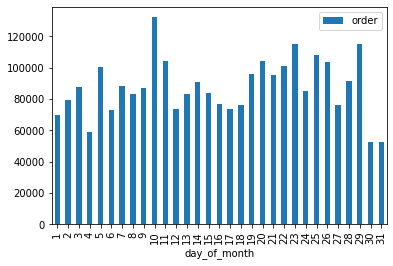

In [ ]:
orders[['order','day_of_month']].groupby('day_of_month').sum().plot.bar()

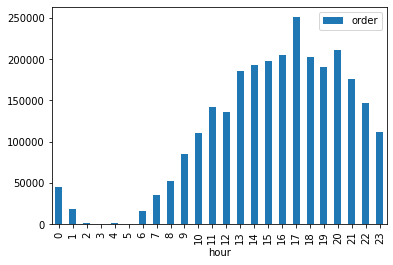

In [ ]:
orders[['order','hour']].groupby('hour').sum().plot.bar()

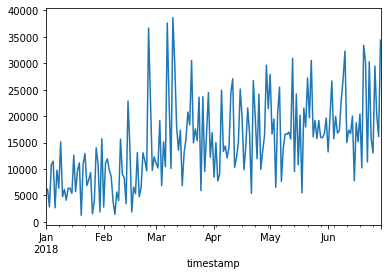

In [ ]:
daily = orders.resample('D').sum()
daily['order'].plot()

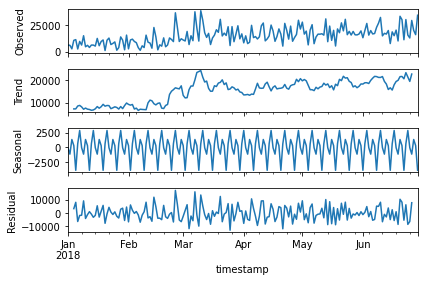

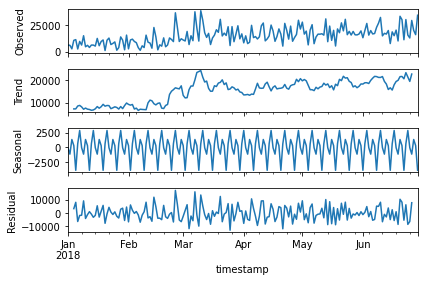

In [ ]:
dec = sm.tsa.seasonal_decompose(daily['order'], model='additive')
dec.plot()

#TODO 1-diff

Discount 'Season' in start of March: 

maybe a new shop?

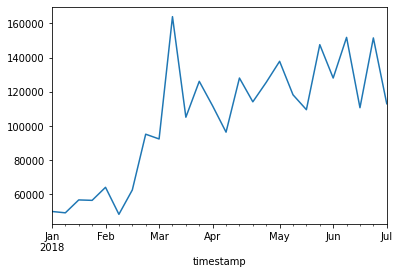

In [ ]:
daily = orders.resample('W').sum()
daily['order'].plot()

# Note for PResentation: -> Only half a year of data

# TODO Promotions per Month/Time

Orders per weekday (0-Mon, 6-Sun)

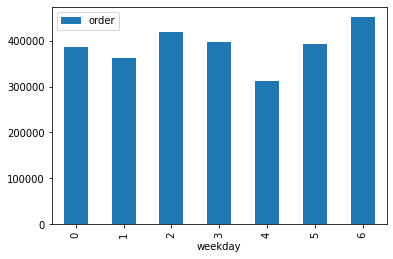

In [ ]:
orders[['order','weekday']].groupby('weekday').sum().plot.bar()

# Opened on Sunday
# Online Shop ? 

# TODO for each month

In [ ]:
orders[['date', 'itemID', 'order']].groupby(['date', 'itemID']).sum()

order
date     itemID       
20180101 9           1
         11          1
         19          2
         26        109
         35        446
...                ...
20180629 10372       1
         10392       1
         10431      19
         10449      52
         10450       2

[100148 rows x 1 columns]

In [ ]:
# add the "daily" sold column to orders
orders = orders.assign(daily_sold = orders.groupby(['date', 'itemID']).order.transform('sum'))

# could also create weekly, monthly 
orders = orders.assign(weekly_sold = orders.groupby(['week_nr', 'itemID']).order.transform('sum'))
orders = orders.assign(monthly_sold = orders.groupby(['month', 'itemID']).order.transform('sum'))

In [ ]:
orders = orders.reset_index(drop=True)

Trying to find dates with exceptionally many sold items of one kind.

Current approach: Mark every day where "daily_sold" is bigger than 10 * mean of all "daily_sold" values for this item.

There must be a better way to detect the days when the item was promoted. And more efficient.

In [ ]:
total_num_days = (orders.time.max() - orders.time.min()).days
def derive_promotion(group):
  unique = group.drop_duplicates(["itemID", "date"]).daily_sold
  all_days = unique.tolist() + [0 for _ in range(total_num_days - len(unique))]
  # limit = 1000 * np.quantile(all_days, 0.5)
  limit = 10 * np.mean(all_days)
  promoted = ",".join(sorted(set(group[group.daily_sold > limit].date)))
  group["promotion_derived"] = promoted if promoted else np.nan
  return group

orders = orders.groupby("itemID").apply(derive_promotion)

In [ ]:
orders

,time,transactID,itemID,order,salesPrice,timestamp,date,hour,day_of_month,month,week_nr,weekday,daily_sold,weekly_sold,monthly_sold,promotion_derived
0,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01 00:01:56,20180101,0,1,1,1,0,4,4,5,20180516
1,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01 00:01:56,20180101,0,1,1,1,0,4,4,5,"20180219,20180226,20180315,20180613"
2,2018-01-01 00:07:11,2255797,7851,2,20.47,2018-01-01 00:07:11,20180101,0,1,1,1,0,3,11,200,"20180125,20180214,20180309,20180505,20180629"
3,2018-01-01 00:09:24,2278968,450,1,17.42,2018-01-01 00:09:24,20180101,0,1,1,1,0,4,4,5,20180516
4,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01 00:09:24,20180101,0,1,1,1,0,4,4,5,"20180219,20180226,20180315,20180613"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181950,2018-06-29 23:54:22,2040347,9217,1,23.50,2018-06-29 23:54:22,20180629,23,29,6,26,4,26,26,33,"20180114,20180518,20180603,20180629"
2181951,2018-06-29 23:55:09,2260943,2175,1,11.60,2018-06-29 23:55:09,20180629,23,29,6,26,4,4,8,15,20180305
2181952,2018-06-29 23:55:09,2260943,2061,1,1.03,2018-06-29 23:55:09,20180629,23,29,6,26,4,8,46,70,"20180420,20180518"
2181953,2018-06-29 23:55:09,2260943,2195,1,18.73,2018-06-29 23:55:09,20180629,23,29,6,26,4,3,14,39,"20180305,20180327,20180406,20180518"


In [23]:
def plot_orders_for_item(item_id):
  orders_ts_index = orders.set_index(pd.DatetimeIndex(orders['timestamp']))
  orders_ts_index[["date", "itemID", "order"]][orders_ts_index.itemID == item_id].resample("D").sum().order.plot()
  plt.title(f'Number of orders sold for item {item_id}', fontdict={'fontsize': 16})
  plt.ylabel(f"Number of orders", fontdict={'fontsize': 16})
  plt.xlabel(f"Time", fontdict={'fontsize': 14})

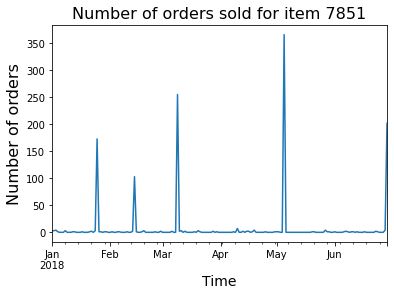

In [24]:
plot_orders_for_item(7851)

In [ ]:
# check for nulls 

orders.isnull().values.any()

True

In [ ]:
orders.groupby('itemID').salesPrice.nunique().sort_values()

itemID
10463     1
2765      1
7795      1
2767      1
5952      1
         ..
3689     16
672      16
2384     17
2531     20
8053     22
Name: salesPrice, Length: 9840, dtype: int64

In [ ]:
non_unique_salesprice = orders.groupby('itemID').salesPrice.nunique() > 1
len(non_unique_salesprice[non_unique_salesprice == True])

6126

In [27]:
def plot_change_in_salesprice(item_id):
    unique = orders.drop_duplicates(["date", "itemID", "salesPrice"])
    unique[unique.itemID == item_id].plot(x = 'time', y = 'salesPrice')
    plt.title(f'Changes in salesPrice for item {item_id}', fontdict={'fontsize': 16})
    plt.ylabel(f"salesPrice", fontdict={'fontsize': 16})
    plt.xlabel(f"Time", fontdict={'fontsize': 14})

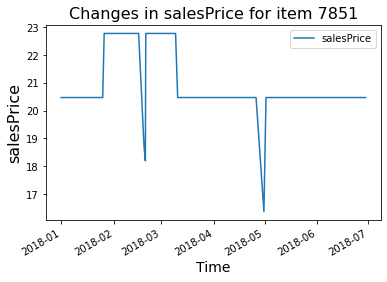

In [28]:
plot_change_in_salesprice(7851)

In [ ]:
orders[orders['itemID'] == 8053]

,time,transactID,itemID,order,salesPrice,timestamp,date,hour,day_of_month,month,week_nr,weekday,daily_sold,weekly_sold,monthly_sold,promotion_derived
4712,2018-01-01 23:05:37,2259665,8053,1,11.39,2018-01-01 23:05:37,20180101,23,1,1,1,0,1,2,74,"20180225,20180311,20180415,20180502,20180609"
36087,2018-01-07 17:48:19,38666,8053,1,11.39,2018-01-07 17:48:19,20180107,17,7,1,1,6,1,2,74,"20180225,20180311,20180415,20180502,20180609"
54671,2018-01-10 10:29:15,56365,8053,1,11.39,2018-01-10 10:29:15,20180110,10,10,1,2,2,70,71,74,"20180225,20180311,20180415,20180502,20180609"
54672,2018-01-10 10:29:15,56364,8053,5,11.39,2018-01-10 10:29:15,20180110,10,10,1,2,2,70,71,74,"20180225,20180311,20180415,20180502,20180609"
54673,2018-01-10 10:29:16,56366,8053,1,11.39,2018-01-10 10:29:16,20180110,10,10,1,2,2,70,71,74,"20180225,20180311,20180415,20180502,20180609"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855800,2018-06-09 17:57:58,1740363,8053,1,8.84,2018-06-09 17:57:58,20180609,17,9,6,23,5,416,416,426,"20180225,20180311,20180415,20180502,20180609"
1858765,2018-06-09 20:23:25,1743186,8053,1,8.84,2018-06-09 20:23:25,20180609,20,9,6,23,5,416,416,426,"20180225,20180311,20180415,20180502,20180609"
1933950,2018-06-14 17:58:08,1813269,8053,1,8.20,2018-06-14 17:58:08,20180614,17,14,6,24,3,1,1,426,"20180225,20180311,20180415,20180502,20180609"
2047158,2018-06-21 21:21:50,2284743,8053,2,8.20,2018-06-21 21:21:50,20180621,21,21,6,25,3,2,2,426,"20180225,20180311,20180415,20180502,20180609"


# 4. Mixed stuff

First a left joining orders <-items <- info

In [ ]:
all_data = orders.join(items, on='itemID', lsuffix='', rsuffix='_items').join(info, 'itemID', rsuffix='_info')
all_data=all_data.drop(columns=['itemID_info','itemID_items'])
all_data.describe()

,transactID,itemID,order,salesPrice,hour,day_of_month,month,weekday,daily_sold,weekly_sold,monthly_sold,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice
count,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181955e+06,2.181954e+06,2.181954e+06,2.181954e+06,2.181954e+06,2.181954e+06,2.181954e+06,2.181954e+06,2.181954e+06
mean,1.073262e+06,5.247717e+03,1.244553e+00,3.668124e+01,1.558241e+01,1.620679e+01,3.963184e+00,3.058482e+00,4.399386e+02,4.697458e+02,5.840208e+02,4.472194e+01,1.136651e+02,1.984627e+00,4.173645e+00,2.339359e+01,4.192752e+00,4.682726e+01,5.071771e+01
std,6.312578e+05,2.454623e+03,6.665127e-01,1.261080e+02,4.832457e+00,8.664219e+00,1.567607e+00,2.027385e+00,5.219669e+02,5.553552e+02,7.017095e+02,5.781642e+01,6.484386e+01,2.266624e+00,1.945079e+00,1.276451e+01,2.145016e+00,2.000235e+02,2.827884e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.460000e+00,3.800000e-01
25%,5.313775e+05,3.605000e+03,1.000000e+00,7.120000e+00,1.300000e+01,9.000000e+00,3.000000e+00,1.000000e+00,1.170000e+02,1.280000e+02,1.570000e+02,0.000000e+00,6.600000e+01,0.000000e+00,2.000000e+00,1.000000e+01,2.000000e+00,1.109000e+01,6.720000e+00
50%,1.065659e+06,5.200000e+03,1.000000e+00,1.668000e+01,1.600000e+01,1.600000e+01,4.000000e+00,3.000000e+00,2.600000e+02,2.850000e+02,3.170000e+02,0.000000e+00,1.020000e+02,0.000000e+00,4.000000e+00,2.300000e+01,4.000000e+00,1.677000e+01,1.571000e+01
75%,1.600670e+06,7.314000e+03,1.000000e+00,3.462000e+01,1.900000e+01,2.400000e+01,5.000000e+00,5.000000e+00,5.390000e+02,5.780000e+02,7.090000e+02,9.200000e+01,1.640000e+02,4.910000e+00,5.000000e+00,3.200000e+01,6.000000e+00,2.862000e+01,3.334000e+01
max,2.294042e+06,1.046300e+04,1.000000e+02,9.387020e+03,2.300000e+01,3.100000e+01,6.000000e+00,6.000000e+00,4.186000e+03,4.812000e+03,4.925000e+03,2.730000e+02,2.530000e+02,5.000000e+00,8.000000e+00,5.200000e+01,8.000000e+00,6.955000e+03,9.055070e+03


In [ ]:
all_data.tail()

NameError: ignored

In [ ]:
all_data[['recommendedRetailPrice','simulationPrice','salesPrice']]
# recommendedRetailPrice: manufacturer's suggestion; fixed
# salesPrice: actual price in a store; varries with time/demand etc.
# simulationPrice: like salesPrice, but in the simulation period (30. 6. 2018 - 13. 7. 2018); 
#       fixed (so that we don't have to predict price changes in the simulation period)

,recommendedRetailPrice,simulationPrice,salesPrice
0,15.69,8.48,17.42
1,33.80,31.45,5.19
2,10.73,4.85,20.47
3,15.69,8.48,17.42
4,33.80,31.45,5.19
...,...,...,...
2181950,296.51,658.28,23.50
2181951,15.03,3.78,11.60
2181952,11.74,4.09,1.03
2181953,19.17,4.97,18.73


In [ ]:
def plot_all_prices(item_id):
    all_data_unique = all_data.drop_duplicates(["date", "itemID", "salesPrice"])
    data_plot = all_data_unique[all_data_unique.itemID == item_id]
    plt.figure(figsize=(12,6))
    plt.plot(data_plot['time'], data_plot['salesPrice'], label = 'salesPrice')
    plt.plot(data_plot['time'], data_plot['recommendedRetailPrice'], label = 'recomendation')
    plt.plot(data_plot['time'], data_plot['simulationPrice'], label = 'simulation')
    plt.title(f'Price information for item {item_id}')
    plt.legend()

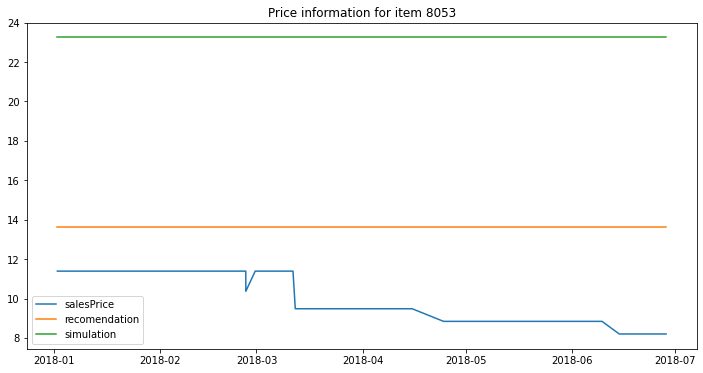

In [ ]:
plot_all_prices(8053)

### Ordinal variables to compare the different prices

In [ ]:
all_data['price_sales_greater_recomm'] = all_data['salesPrice'] > all_data['recommendedRetailPrice']
all_data['price_sales_greater_sim'] = all_data['salesPrice'] > all_data['simulationPrice']
all_data['price_recomm_greater_sim'] = all_data['recommendedRetailPrice'] > all_data['simulationPrice']

In [ ]:
f"{all_data['price_sales_greater_recomm'].sum() / all_data['price_sales_greater_recomm'].count()} % of sales prices are higher than recommended prices"

'0.4767508954126002 % of sales prices are higher than recommended prices'

In [ ]:
f"{all_data['price_sales_greater_sim'].sum() / all_data['price_sales_greater_sim'].count()} % of sales prices are higher than simulation prices"

'0.5172370649257203 % of sales prices are higher than simulation prices'

In [ ]:
f"{all_data['price_recomm_greater_sim'].sum() / all_data['price_recomm_greater_sim'].count()} % of recommended prices are higher than simulation prices"

'0.5769436124942998 % of recommended prices are higher than simulation prices'

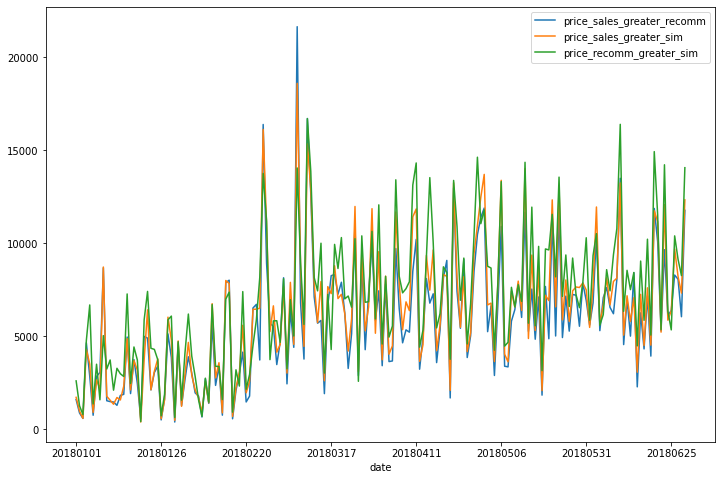

In [ ]:
(all_data[['date','price_sales_greater_recomm','price_sales_greater_sim','price_recomm_greater_sim']]).groupby('date').sum().plot(figsize = (12,8))

#TODO -> Diff between price -> plotted
#TODO -> salesprice / recomm price as feature
#TODO upper feature in correlation with number of orders

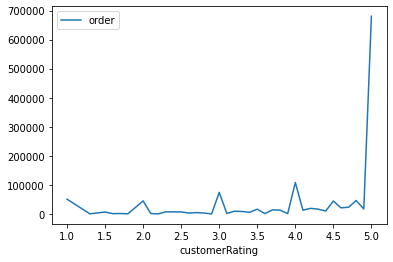

In [ ]:
all_data[all_data['customerRating'] > 0][['customerRating','order']].round(1).groupby('customerRating').sum().plot()

# here changed the decimal places to 1 instead of 0 to see more detailed trend 

# If an item was bought multiple times, it is counted multiple times in this plot, right?

##Price vs rating

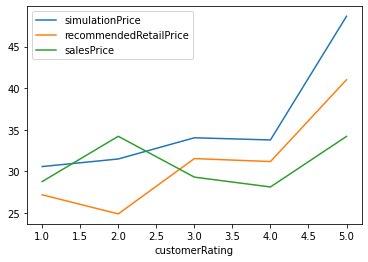

In [ ]:
all_data[all_data['customerRating'] > 0][['customerRating','simulationPrice','recommendedRetailPrice','salesPrice']].round(0).groupby('customerRating').mean().plot()

In [ ]:
all_data["Price_difference_sales_recomm"] = (all_data['salesPrice'] - all_data['recommendedRetailPrice'])/ all_data['salesPrice']
all_data["Price_difference_sales_sim"] = (all_data['salesPrice'] - all_data['simulationPrice'])/all_data['salesPrice']

def color_crazy_correlations(val):
    """
    Function to color correlation based on the value.
    """
    
    color = 'black'
    if abs(val) > 0.7:
      color = 'red'
    if abs(val) > 0.5:
      color = 'green'

    return 'color: %s' % color

corr = all_data.corr()
corr = corr.drop(columns=['transactID','itemID'], index=['transactID','itemID'])
corr.style.applymap(color_crazy_correlations).format("{:.2%}", na_rep="-")


,order,salesPrice,hour,day_of_month,month,weekday,daily_sold,weekly_sold,monthly_sold,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,price_sales_greater_recomm,price_sales_greater_sim,price_recomm_greater_sim,Price_difference_sales_recomm,Price_difference_sales_sim
order,100.00%,-5.71%,2.41%,-1.08%,-0.40%,-0.27%,16.45%,17.88%,18.20%,0.43%,10.02%,3.97%,11.44%,13.74%,14.28%,-3.54%,-2.61%,-3.57%,-2.29%,0.47%,-0.73%,-0.63%
salesPrice,-5.71%,100.00%,0.02%,-0.81%,-1.67%,2.00%,-10.30%,-10.33%,-10.27%,8.95%,0.42%,-2.74%,1.74%,0.80%,1.38%,20.26%,15.73%,16.85%,13.89%,0.21%,4.54%,3.84%
hour,2.41%,0.02%,100.00%,0.73%,-3.89%,-2.90%,17.93%,15.76%,13.38%,0.65%,2.37%,2.19%,2.79%,4.58%,1.17%,-2.74%,-2.12%,0.30%,0.32%,-0.99%,1.99%,1.50%
day_of_month,-1.08%,-0.81%,0.73%,100.00%,-5.27%,-3.53%,-0.51%,-1.91%,-1.14%,4.98%,1.56%,1.01%,-0.96%,1.01%,0.82%,-2.09%,-1.58%,0.57%,0.52%,0.13%,1.88%,1.63%
month,-0.40%,-1.67%,-3.89%,-5.27%,100.00%,3.66%,-11.02%,-12.52%,-15.10%,0.33%,3.60%,-10.40%,-5.13%,-3.56%,-3.82%,-3.04%,-2.71%,-2.12%,-1.24%,-0.85%,0.10%,-0.08%
weekday,-0.27%,2.00%,-2.90%,-3.53%,3.66%,100.00%,5.13%,5.43%,4.11%,-0.00%,-2.76%,0.06%,4.02%,-0.37%,2.01%,1.06%,0.80%,-0.07%,-0.94%,0.85%,0.18%,0.07%
daily_sold,16.45%,-10.30%,17.93%,-0.51%,-11.02%,5.13%,100.00%,96.50%,84.49%,2.29%,14.06%,13.29%,19.82%,24.08%,17.94%,-7.67%,-5.99%,0.47%,-2.95%,-2.00%,1.58%,1.43%
weekly_sold,17.88%,-10.33%,15.76%,-1.91%,-12.52%,5.43%,96.50%,100.00%,88.29%,1.68%,12.88%,13.74%,20.47%,23.18%,17.20%,-7.32%,-5.77%,-0.22%,-3.43%,-1.34%,1.06%,1.05%
monthly_sold,18.20%,-10.27%,13.38%,-1.14%,-15.10%,4.11%,84.49%,88.29%,100.00%,1.59%,9.06%,13.56%,22.10%,20.38%,15.34%,-7.02%,-5.66%,-0.12%,-2.96%,-0.83%,0.42%,0.51%
brand,0.43%,8.95%,0.65%,4.98%,0.33%,-0.00%,2.29%,1.68%,1.59%,100.00%,47.18%,7.94%,30.25%,48.72%,53.41%,6.52%,3.66%,0.16%,0.70%,-2.49%,1.18%,1.99%


In [ ]:
daily = all_data.resample('D').sum()
print(daily.head())
decomposition = sm.tsa.seasonal_decompose(daily['order'], model='additive')
decomposition.plot()

TypeError: ignored

TODO: 

[ ]- Table for rows -> days | col-> item --> Are Items correlated (in orders)

In [ ]:
 
all_data['time'] =  pd.to_datetime(all_data['time'])
all_data['time'] = all_data['time'].dt.round('1D')
all_data_aggr1 = all_data[["time","itemID","salesPrice","order"]].groupby(["time","itemID","salesPrice"]).count()
all_data_aggr2 = all_data[["time","itemID","salesPrice","customerRating","Price_difference_sales_recomm","Price_difference_sales_sim",'price_sales_greater_recomm','price_sales_greater_sim']].groupby(["time","itemID","salesPrice",]).mean()
all_data_aggr2 = all_data[["time","itemID","salesPrice","customerRating","Price_difference_sales_recomm"]].groupby(["itemID"]).mean()
all_data_aggr = all_data_aggr1.join(all_data_aggr2, on=["time","itemID","salesPrice"])

all_data_aggr.tail()

ValueError: ignored

In [ ]:

corr2 = all_data_aggr.corr()

corr2.style.applymap(color_crazy_correlations).format("{:.2%}", na_rep="-")

NameError: ignored

In [ ]:
all_data_aggr.reset_index(inplace = True)

corr3 = all_data_aggr[all_data_aggr.itemID == 1].corr()
corr3.style.applymap(color_crazy_correlations).format("{:.2%}", na_rep="-")
